In [4]:
import os
import numpy as np
import collections
from statsmodels.stats import multitest
import sys
sys.path.append('../../scripts/')
sys.path.append('../utils/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'system', colors='banskt')

import load_results
import precision_recall_scores as roc

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()

In [5]:
sigmabeta = ['0.001', '0.01', '0.05', '0.1', '0.2', '0.5', '1.0']

In [9]:
srcdir = "/scratch/sbanerj/trans-eqtl/simulation/10414_450_10_800_30_100_100_0.01_0.5_0.0_0.6_0.6_4.0_0.1_20_0.02"
#perm_sbeta = "0.01"
simlist = list(range(0, 10))

def read_data(key, filename, truth):
    valres = list()
    for key, value in load_results.tejaas(filename).items():
        caus = 1 if key in truth else 0
        valres.append(ValidateResult(rsid = key, stat = value, causality = caus))
    return valres


rdata = dict()
for key in sigmabeta:
    rdata[key] = [None for x in simlist]

for perm_sbeta in sigmabeta:
    for i, simidx in enumerate(simlist):
        simdir = "sim{:03d}".format(simidx + 1)
        sim_trans_file  = os.path.join(srcdir, simdir, "input/expression.trans")
        sim_cis_file    = os.path.join(srcdir, simdir, "input/expression.cis")
        rr_outfile      = os.path.join(srcdir, simdir, "tejaas/permnull_sb{:s}_knn/raw/peer0/rr.txt".format(perm_sbeta))
        #rr_randfile     = os.path.join(srcdir, simdir, "tejaas_rand/permnull_sb{:s}/rr.txt".format(perm_sbeta))

        true_trans = list()
        with open(sim_trans_file, 'r') as fin:
            for line in (fin):
                linesplit = line.strip().split()
                true_trans.append(linesplit[1])

        rdata[perm_sbeta][i] = read_data('rr', rr_outfile, true_trans)

In [10]:
def get_plotvals(res):
    nsim = len(res)
    print("Number of simulations: {:d}".format(nsim))
    nsel   = [None for x in range(nsim)]
    tpr    = [None for x in range(nsim)]
    ppv    = [None for x in range(nsim)]
    fpr    = [None for x in range(nsim)]
    valids = [None for x in range(nsim)]
    thres  = [None for x in range(nsim)]
    for i in range(nsim):
        #print(i)
        nsel[i], tpr[i], ppv[i], valids[i], thres[i], fpr[i] = roc.confusion_matrix(res[i])
    print("Number of thresholds: ", [len(x) for x in thres])
    return nsel, tpr, ppv, valids, thres, fpr

def avgplot(ax, xx, yy, label, reverse = False):
    nsim = len(xx)
    nx = int(2 * np.max([len(x) for x in thres]))
    xmax = int(np.max([max(x) for x in xx]) + 0.5)
    xvals = np.linspace(0, xmax, nx)
    if not reverse:
        yest_arr = np.array([np.interp(xvals, xx[i], yy[i]) for i in range(nsim)])
    else:
        yest_arr = np.array([np.interp(xvals, xx[i][::-1], yy[i][::-1]) for i in range(nsim)])
    yest = np.mean(yest_arr, axis = 0)
    yerr = np.std (yest_arr, axis = 0)
    ax.plot(xvals, yest, label = label)

0.001:
Number of simulations: 10
Number of thresholds:  [10405, 10403, 10402, 10409, 10400, 10402, 10394, 10403, 10407, 10407]
0.01:
Number of simulations: 10
Number of thresholds:  [10415, 10415, 10414, 10415, 10415, 10415, 10415, 10415, 10415, 10414]
0.05:
Number of simulations: 10
Number of thresholds:  [10415, 10415, 10415, 10415, 10415, 10415, 10414, 10415, 10415, 10415]
0.1:
Number of simulations: 10
Number of thresholds:  [10414, 10415, 10415, 10415, 10414, 10414, 10415, 10415, 10411, 10414]
0.2:
Number of simulations: 10
Number of thresholds:  [10413, 10411, 10410, 10410, 10414, 10410, 10408, 10408, 10410, 10411]
0.5:
Number of simulations: 10
Number of thresholds:  [10151, 10182, 10057, 10091, 10070, 10143, 10114, 10172, 10322, 10260]
1.0:
Number of simulations: 10
Number of thresholds:  [9406, 10248, 9058, 9544, 9195, 9762, 9226, 10213, 10337, 10284]


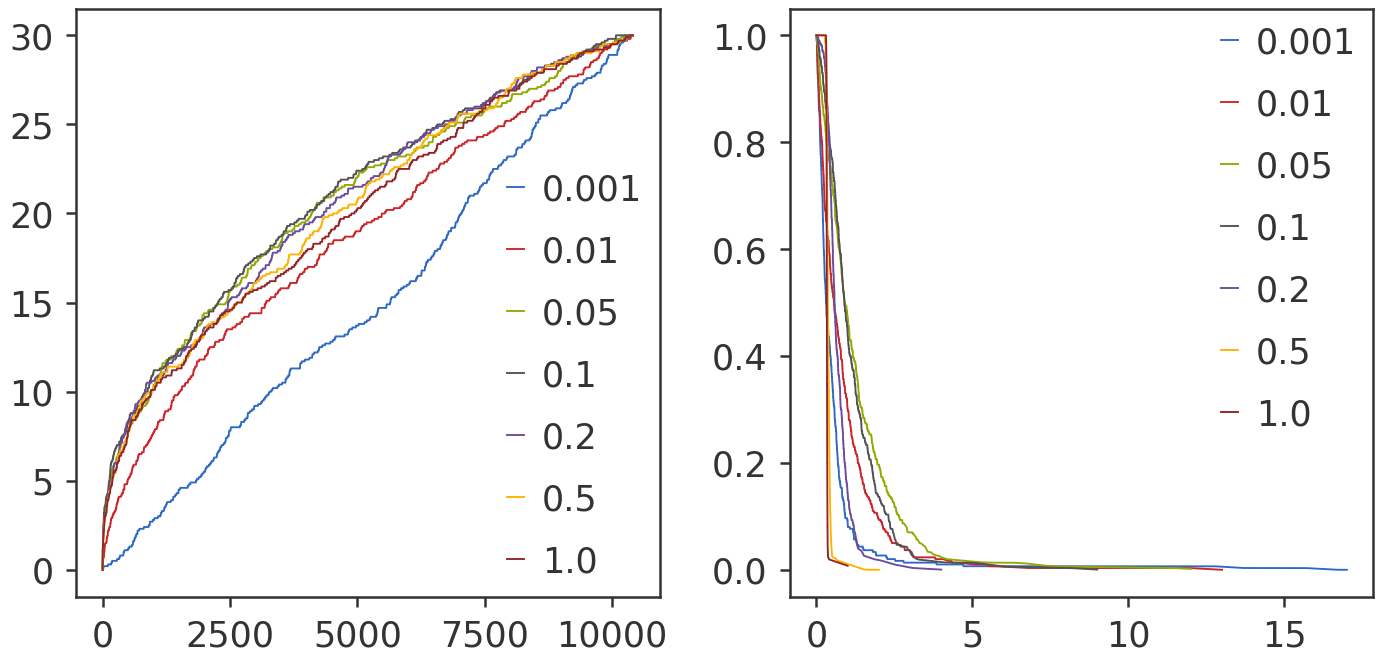

In [11]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for key in sigmabeta:
    print('{:s}:'.format(key))
    nsel, tpr, ppv, valids, thres, fpr = get_plotvals(rdata[key])
    avgplot(ax1, nsel, valids, key)
    avgplot(ax2, thres, tpr, key, reverse = True)

ax1.legend()
#ax1.set_xlim([0, 200])
ax2.legend()
#ax1.set_xlim([0, 200])
plt.tight_layout()
#plt.savefig(outfile, bbox_inches='tight')
plt.show()